### Logistic Regression models

**Objective**: This notebook aims to analyse customer reviews using Logistic Regression models to predict certain outcomes based on the text data. The goal is to understand the sentiment or other characteristics of the reviews that could be beneficial for business insights.

**Methodology**: We have employed Logistic Regression with L1 regularisation to optimise the model's performance, which helps in feature selection by penalising less important features. The data is vectorised using 1 and 2-grams to capture the context within the text effectively. 

**Data**: The analysis uses a dataset of customer reviews that has been preprocessed and vectorized. The dataset was split into training and testing sets, with downsampling applied to address class imbalance, ensuring that our model is robust and less biased. I run the optimisation on each dataset (Balanced and unbalanced) and compare the results.

**Key Findings**: The top three words associated with positive reviews are "love", "great" and "perfect". The top three words associated with negative reviews are "return", "broke" and "waste". This is consistant between both models. We are focusing on being able to **correctly identify negative reviews** and to infer the most common issues cutsomers have with products. So I will quote the recall of class 0: The model on unbalanced data scored an recall of $0.31$, and the model on balanced data achieved an accuracy of $0.83$. More analysis takes place in the notebook.

In [17]:
# standard library imports
import joblib

# data handling and plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%config InlineBackend.figure_format = "retina"
plt.rcParams['figure.figsize'] = (20, 10)

# machine learning and utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

# local source imports
from source import downsample_binary, my_tokenizer

# interpretability tools
import lime
import lime.lime_tabular

In [18]:
# feature union for the vectoriser, easiest way to guarantee 500 1-grams and 100 2-grams 
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
# feature union to combine 1-gram and 2-gram features
combined_features = FeatureUnion([
    ('1gram', tfidf),
    ('2gram', tfidf_2grams)
])

Begin by reading in the data, then I will optimise for best C value using $L1$ Regression. Before doing this, I will split the data into test and train, and make a copy of the train set before downsampling the majority class. I will train two logistic regressions on each dataset and compare the results. I am using the vectorisation with 1 and 2-grams

In [19]:
df = pd.read_pickle("../data/reviews_vector_FINAL.pkl")

In [20]:
# Splitting the main data
X=df.drop("binary",axis=1)
y=df["binary"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
# this is used in evaluation
test_later = X_test

In [22]:
#downsampling X_train
balanced_set = downsample_binary(y_train, X_train)

I keep an unvectorised train set and a prevectorised train set so that we can tune the hyperparamters with out having to apply the vectoriser every cross-validation, saving compute. I recognise that this leaks the validation set, however, the test set is kept hidden til evaltuation. 


In [23]:
X_train_unvec = X_train["reviewText"]
X_train = X_train[X_train.columns[4:]]
X_test_unvec = X_test["reviewText"]
X_test = X_test[X_test.columns[4:]]


In [24]:
# balanced class training sets
X_train_bal = balanced_set[balanced_set.columns[5:]]
y_train_bal = balanced_set["binary"]

X_train_bal_unvec = balanced_set["reviewText"]



After binning the reviews rated 1,2 or 3 stars together as "0" or negative, and the reviews rated 4 or 5 stars as "1" or positive, the distribution below:

In [25]:
y_train.value_counts(normalize=True), y_train_bal.value_counts(normalize=True)

(binary
 1    0.761183
 0    0.238817
 Name: proportion, dtype: float64,
 binary
 0    0.5
 1    0.5
 Name: proportion, dtype: float64)

In [26]:
# checking that the downsample worked
y_train.value_counts(), y_train_bal.value_counts()

(binary
 1    432829
 0    135798
 Name: count, dtype: int64,
 binary
 0    135798
 1    135798
 Name: count, dtype: int64)

### Optimizing a Logistic Regression on the original unbalanced data
I will finetune the $C$ hyperparameter: *Inverse of regularization strength*. I performed a larger search, however the change in cross-validation accuracy is so tiny with C values between $0.1$ going up in powers of ten to even $1000$.


In [27]:
# instansiate the pipeline
estimators = [('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe = Pipeline(estimators)

In [28]:
# run a grid search for the model on unbalanced data
params = {
    'model__penalty':['l1'],
    'model__solver':['liblinear'],
    'model__C': [0.1,1,10,15],
    'model__random_state':[42]    
}

grid_search = GridSearchCV(pipe, param_grid=params, verbose=3, n_jobs=2)

In [26]:
# fit the grid search
fittedgrid = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.5min
[CV 2/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.858 total time= 2.6min
[CV 3/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.856 total time= 2.2min
[CV 4/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.3min
[CV 5/5] END model__C=0.1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.5min
[CV 1/5] END model__C=1, model__penalty=l1, model__random_state=42, model__solver=liblinear, normalise=StandardScaler();, score=0.857 total time= 2.4min
[CV 3/5] END

In [ ]:
fittedgrid.best_estimator_

I have tuned the C value of the logistic regression. I have also done a larger range, which is not included as almost all C values yield very similar cross-validation scores. I have gone with a C value of 10 as recommended. 

I will set a final pipeline with the vectoriser and the best estimator found in the grid search. I can then serialize the model, so we can use it in other notebooks, as well as deploying it. (Streamlit app)

In [ ]:

estimators = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators, verbose=True)
pipe_final.fit(X_train_unvec, y_train)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] ......... (step 1 of 2) Processing vectorize, total= 4.0min
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.7s


Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x169999700>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x169999700>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

### Optimizing a Logistic Regression on the balanced data
I will finetune the $C$ hyperparameter: *Inverse of regularization strength*. As before, I performed a larger search, however the change in cross-validation accuracy is so tiny with C values between $0.1$ going up in powers of ten to even $1000$.

In [14]:
# instansiate the balanced pipeline
estimators_bal = [
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_bal = Pipeline(estimators_bal)

In [15]:
# run a grid search for the model on balanced data
params_bal = {
    'model__C': [0.1,1,10],
    'model__random_state':[42]
    
}

grid_search_bal = GridSearchCV(pipe_bal, param_grid=params_bal, verbose=3, n_jobs=2)

In [ ]:
fittedgrid_bal = grid_search_bal.fit(X_train, y_train)

In [ ]:
fittedgrid_bal.best_estimator_

I have tuned the C value of the logistic regression. I have also done a largeer range, which is not included as almost all C values yield very similar cross-validation scores. I have gone with a C value of 10 as recommended. 

In [ ]:
estimators_bal = [('vectorize', combined_features), 
              ('model', LogisticRegression(C=10,penalty='l1', solver='liblinear',random_state=42))]
pipe_final_bal  = Pipeline(estimators_bal, verbose=True)
pipe_final_bal.fit(X_train_bal_unvec, y_train_bal)

Serializing the models:

In [31]:
joblib.dump(pipe_final, "../model/logistic-unbal-model.pkl")
joblib.dump(pipe_final_bal, "../model/logistic-bal-model.pkl")



['../model/logistic-bal-model.pkl']

In [29]:
# pipe_final = joblib.load("../model/logistic-unbal-model.pkl")
# pipe_final_bal = joblib.load("../model/logistic-bal-model.pkl")



# Evaluation:
1. Coeffiecents of models
2. Confusion matricies and classification reports 
3. ROC
4. SHAP


We now have ```pipe_final``` on the unbalanced data and ```pipe_final_bal``` on the balanced data. We can now compare the two.

In [30]:
log_clas = pipe_final[-1]
log_clas_bal = pipe_final_bal[-1]

In [31]:
# predictions for unbalanced
y_pred_train = pipe_final.predict(X_train_unvec)
y_pred_test = pipe_final.predict(X_test_unvec)

In [32]:
# predictions for balanced
y_pred_train_bal = pipe_final_bal.predict(X_train_bal_unvec)
y_pred_test_bal = pipe_final_bal.predict(X_test_unvec)


In [33]:
# for ROC later
y_proba_test = pipe_final.predict_proba(X_test_unvec)
y_proba_test_bal = pipe_final_bal.predict_proba(X_test_unvec)

In [36]:
accuracy_score(y_train, y_pred_train),accuracy_score(y_test, y_pred_test)

(0.7348244103779806, 0.7341882566458212)

In [37]:
accuracy_score(y_train_bal, y_pred_train_bal),accuracy_score(y_test, y_pred_test_bal)

(0.8237013799908688, 0.8170895559135323)

We can see that based on accuracy, the model trained on the smaller, balanced class dataset performs better. However, as I said previously, we really want to focus on the negative class, and so I will evaluate them in more depth next. I will start with plotting the features with biggest coefficients of each model.
Outline of ev

In [118]:
feature_unbal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final[0].get_feature_names_out())]
feature_bal = [x.replace('1gram__', '').replace('2gram__', '') for x in list(pipe_final_bal[0].get_feature_names_out())]

## Plotting highest coefficients for positive and negative sentiment

In [186]:
log_clas.coef_.shape

(1, 600)

In [119]:
word_counts = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=feature_unbal
).sort_values("coefficients", ascending=False)
# word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

# plt.title("The 20 highest model coefficients indicating positive sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [120]:
# word_counts.head(5).plot(kind="bar", figsize=(10, 5), legend=False)

# plt.title("The 5 highest model coefficients indicating positive sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [126]:
word_counts2 = pd.DataFrame(
    {"coefficients": log_clas.coef_[0]},
    index=feature_unbal
).sort_values("coefficients", ascending=True)

# word_counts2.head(50).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

# plt.title("The 20 highest model coefficients indicating negative sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [127]:
# word_counts2.head(5).abs().plot(kind="bar", figsize=(10, 5), legend=False, color='red')

# plt.title("The 5 highest model coefficients indicating negative sentiment")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

Here are the top 5 words signifiying negative reviews. 

In [128]:
p = word_counts.head(5)
n = word_counts2.head(5)
p.columns = ['pos']
n.columns = ['neg']
p_and_n = pd.concat([p,n])


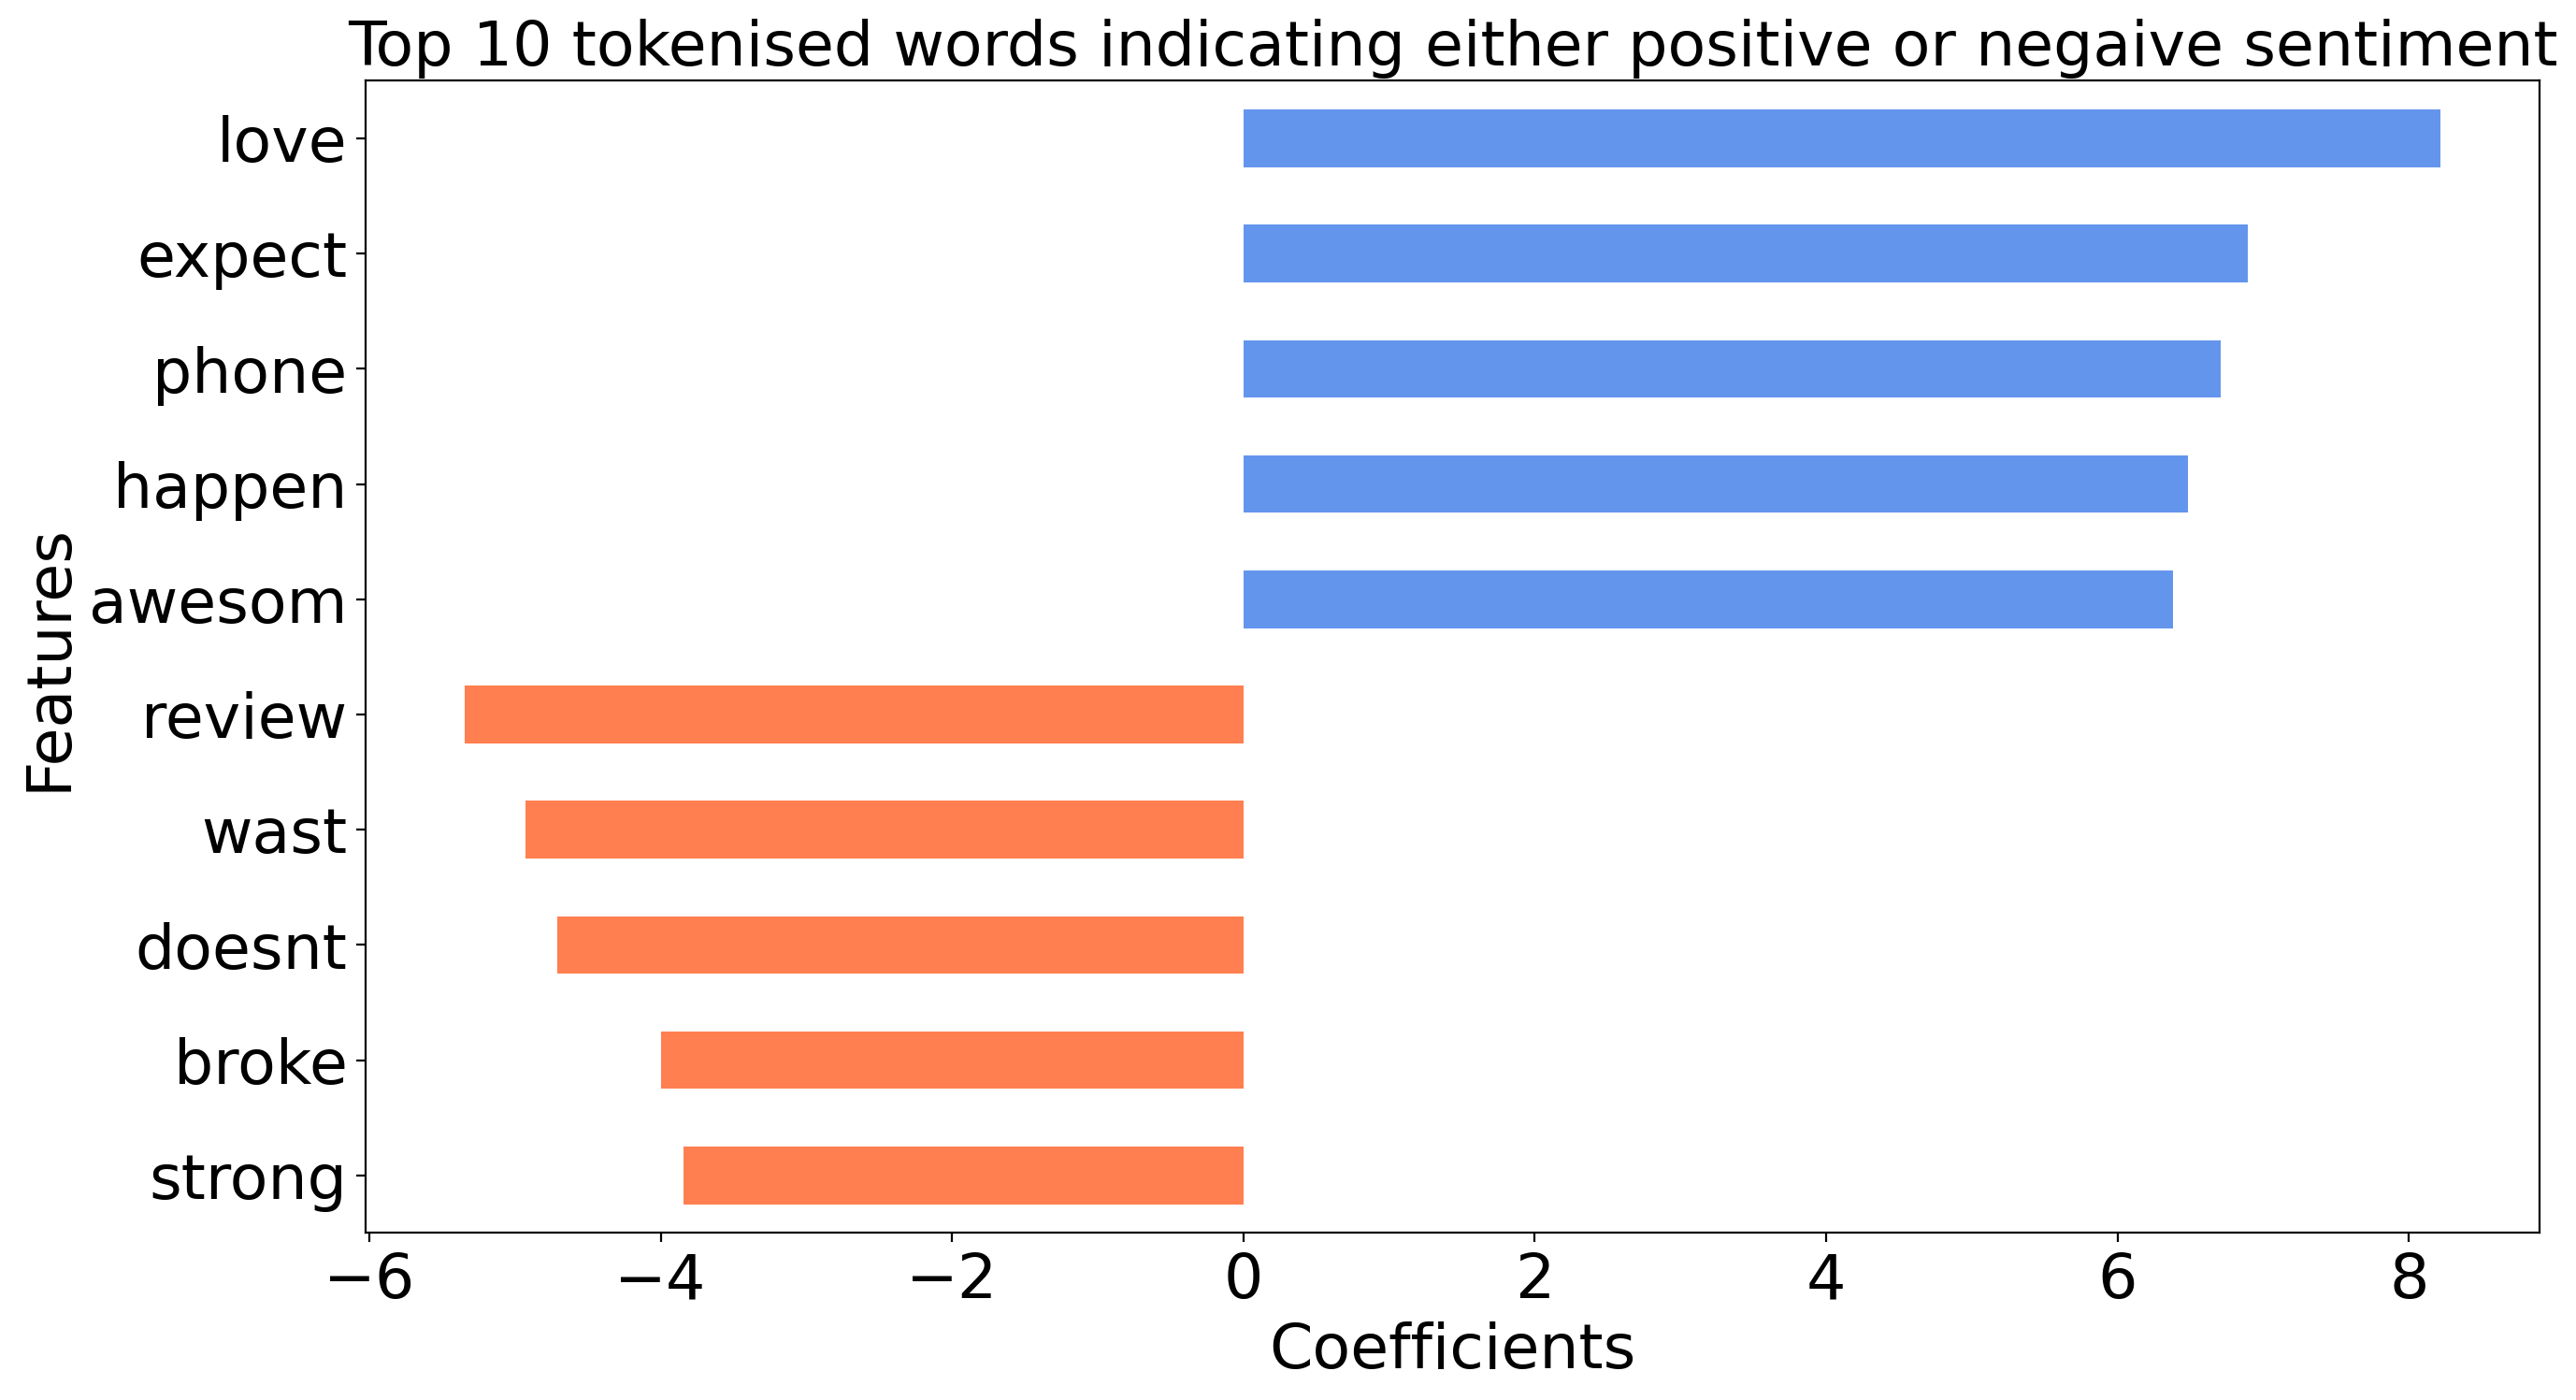

In [135]:
# colouring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data = p_and_n.stack().reset_index()
stacked_data.columns = ['feature', 'type', 'coefficient']
stacked_data
sorted_data = stacked_data.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['cornflowerblue' if tp=="pos"  else 'coral' for tp in sorted_data['type']]

# plot
plt.figure(figsize=(15,8))
sorted_data.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Top 10 tokenised words indicating either positive or negaive sentiment", fontsize=24)
plt.ylabel("Features", fontsize=24)
plt.xlabel("Coefficients", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.xticks(rotation=0)

plt.show()

REVIEW, waste, doesnt broke strong all negative, love, expect, phone, happen

The same results for the balanced data, but in a slightly different order. It is interesting that no 2-grams were chosen as very important. maybe this was an unececary step and we can test this in future.

In [136]:
word_counts_bal = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=feature_bal
).sort_values("coefficients", ascending=False)

# word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)

# plt.title("The 20 highest model coefficients indicating positive sentiment - downsampled")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [137]:
word_counts_bal2 = pd.DataFrame(
    {"coefficients": log_clas_bal.coef_[0]},
    index=feature_bal
).sort_values("coefficients", ascending=True)

# word_counts.head(20).abs().plot(kind="bar", figsize=(15, 5), legend=False, color='red')

# plt.title("The 20 highest model coefficients indicating negative sentiment - downsampled")
# plt.ylabel("Coefficients")
# plt.xticks(rotation=45)
# plt.show()

In [138]:
p_bal = word_counts_bal.head(5)
n_bal = word_counts_bal2.head(5)
p_bal.columns = ['pos']
n_bal.columns = ['neg']
p_and_n_bal = pd.concat([p_bal,n_bal])


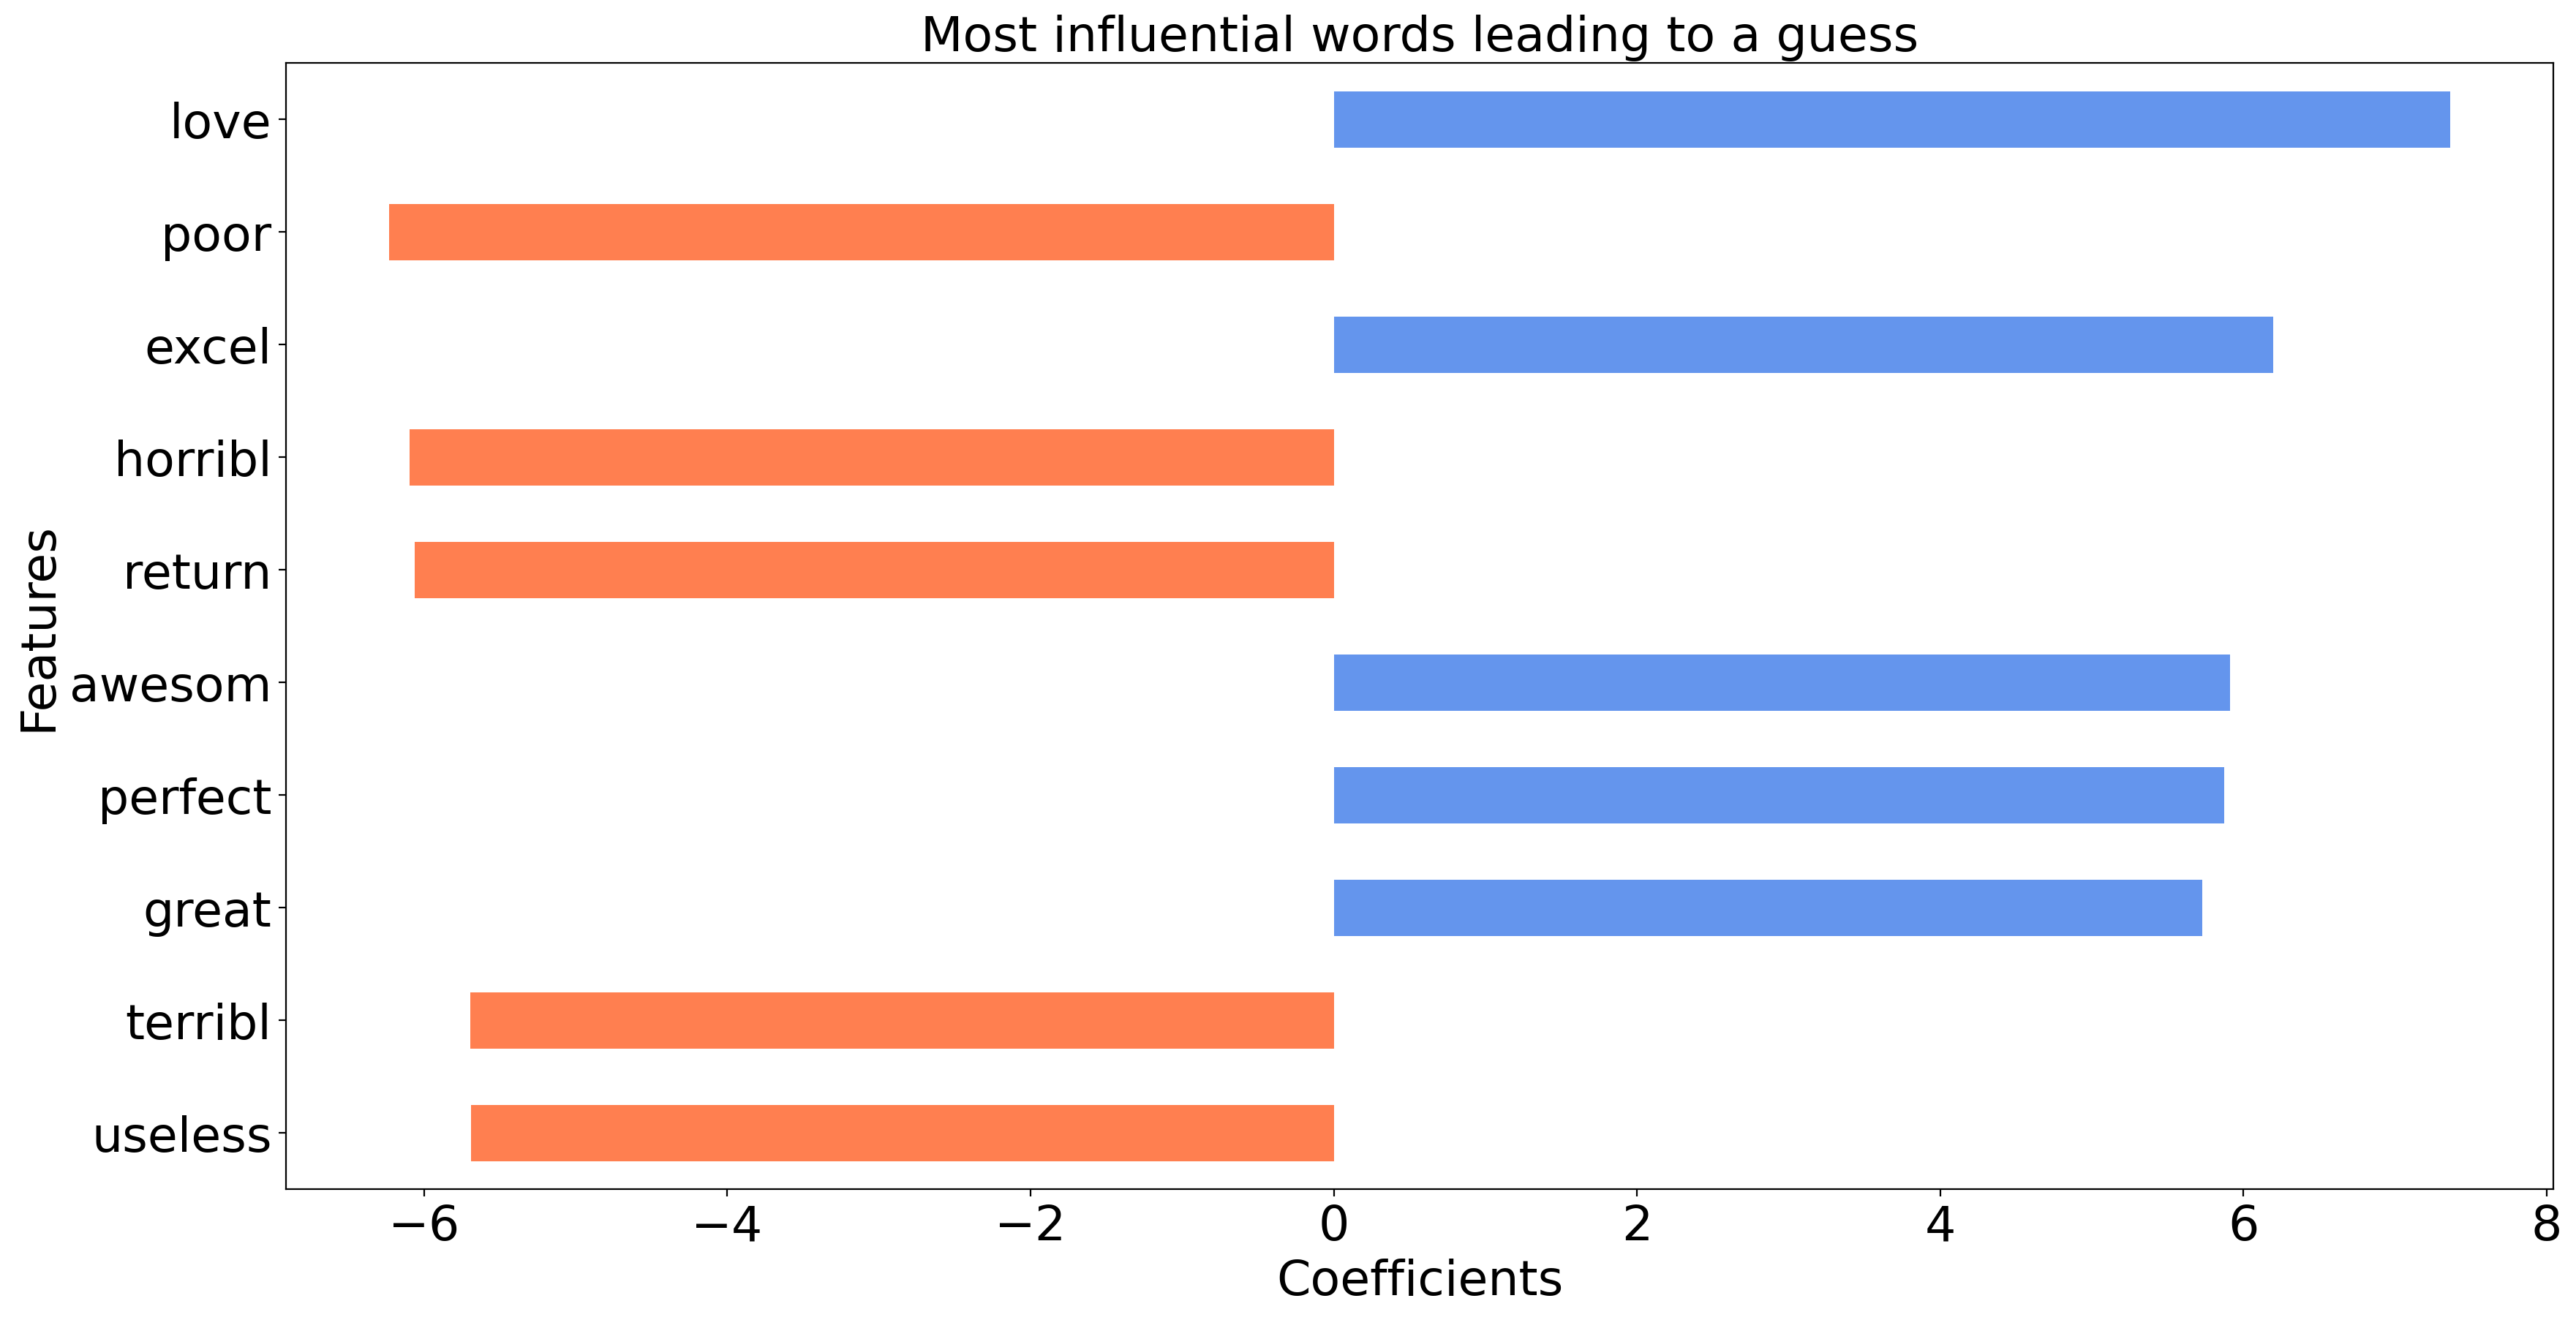

In [139]:
# colouring from https://stackoverflow.com/questions/3832809/how-to-change-the-color-of-a-single-bar-if-condition-is-true
stacked_data_bal = p_and_n_bal.stack().reset_index()
stacked_data_bal.columns = ['feature', 'type', 'coefficient']
stacked_data_bal
sorted_data_bal = stacked_data_bal.sort_values(by='coefficient', key=abs, ascending=True)

colors = ['cornflowerblue' if tp=="pos"  else 'coral' for tp in sorted_data_bal['type']]

# plot
plt.figure()
sorted_data_bal.set_index('feature')['coefficient'].plot(kind="barh", color=colors, legend=False)
plt.title("Most influential words leading to a guess", fontsize=24)
plt.ylabel("Features", fontsize=24)
plt.xlabel("Coefficients", fontsize=24)

plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()

We see that both in the positive and negative reviews the same words appear, although in slightly different orders. Many words we expect such as love, great, perfect indicate positive reviews, whilst words such as return waste dissapoint indicate a negative review. Lets look further into the predictions

Confusion matrix

In [140]:
# unbalanced
cm = confusion_matrix(y_test, y_pred_test)
cm_norm = confusion_matrix(y_test, y_pred_test , normalize="true")

In [141]:
# balanced
cm_bal = confusion_matrix(y_test, y_pred_test_bal)
cm_bal_norm = confusion_matrix(y_test, y_pred_test_bal, normalize="true")

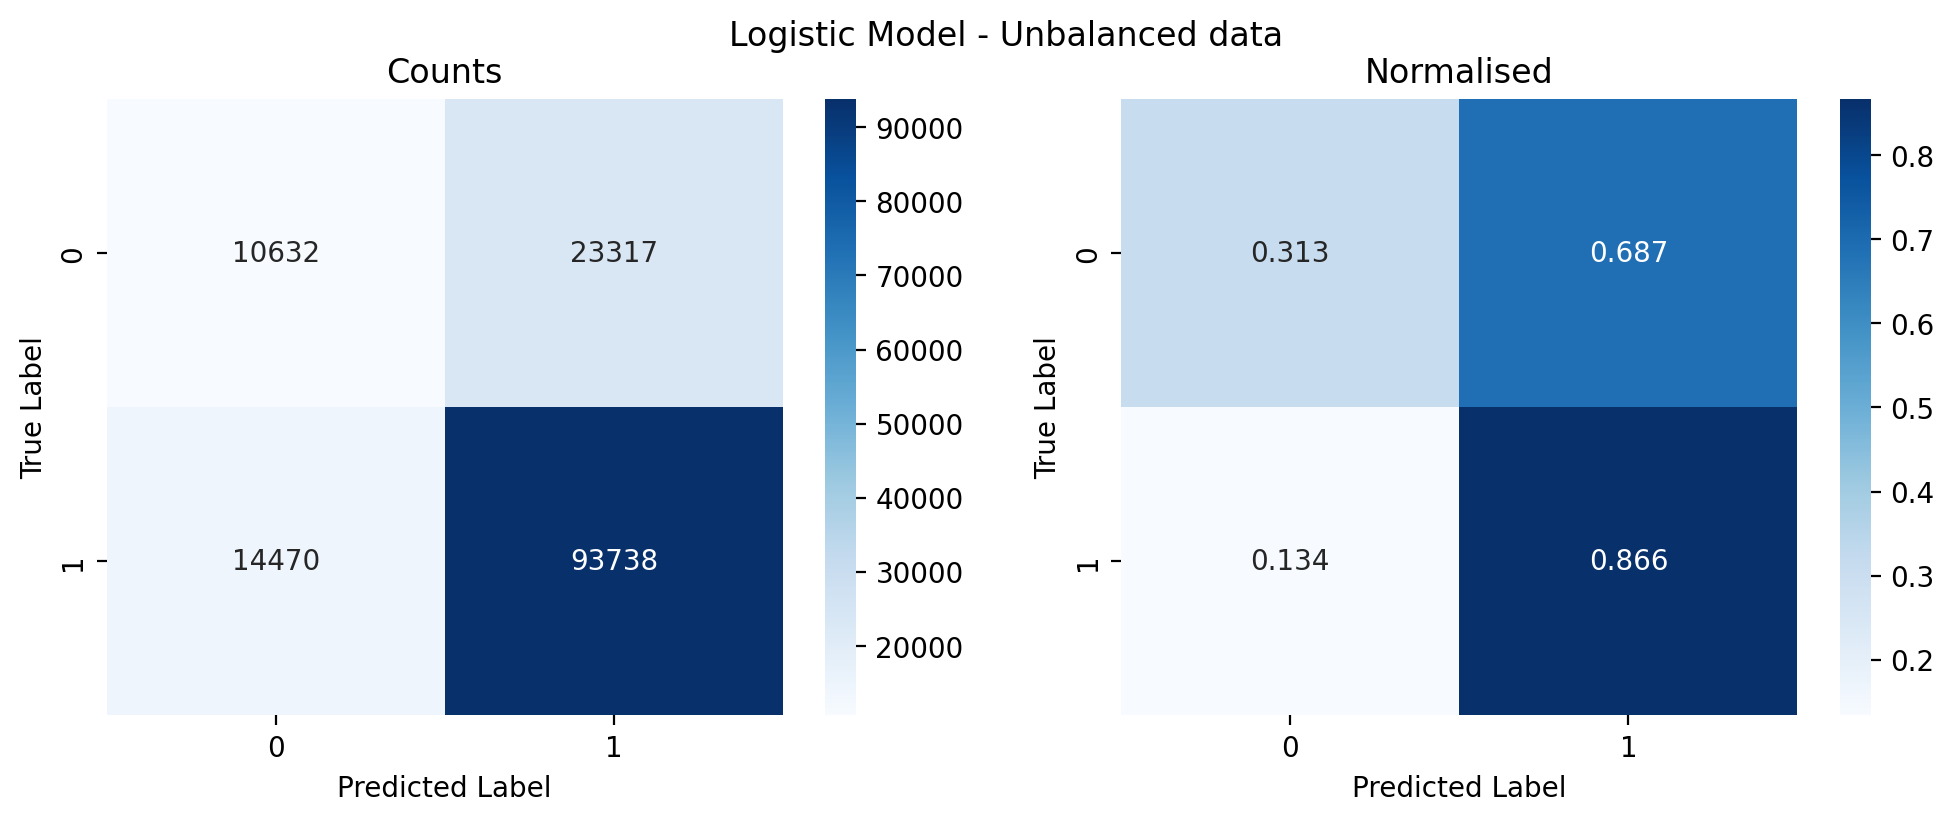

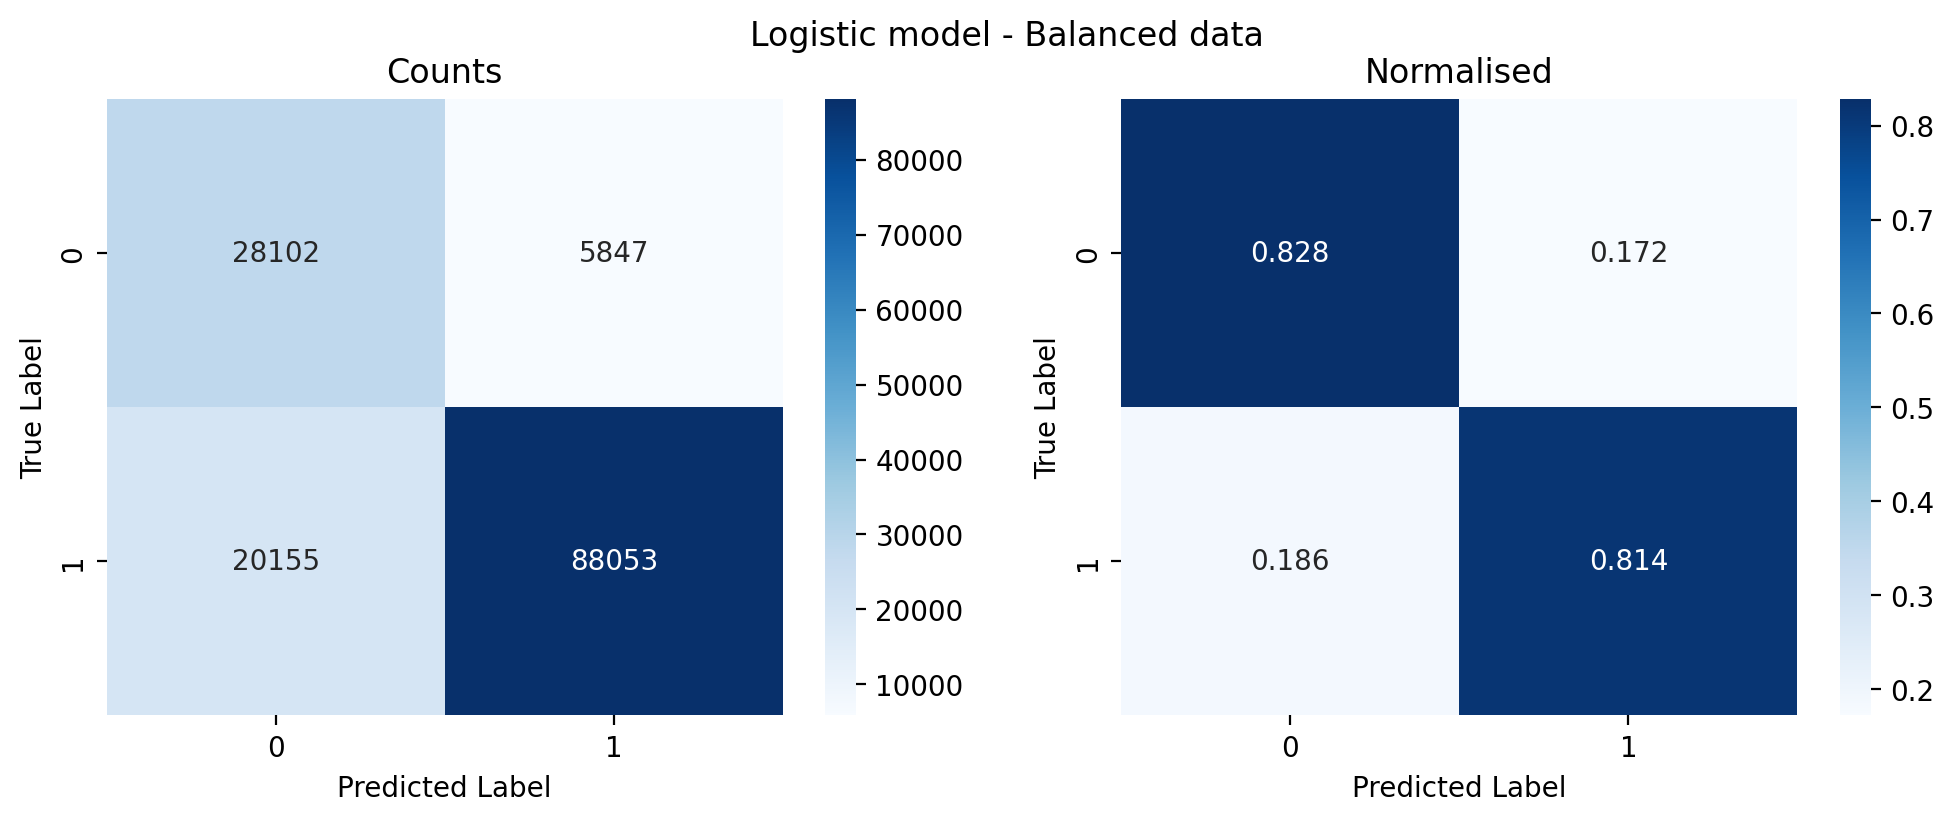

In [142]:
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Logistic Model - Unbalanced data")
plt.show()
plt.subplots(1,2, figsize=(12, 4))
plt.subplot(1,2,1)
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Counts")
plt.subplot(1,2,2)
sns.heatmap(cm_bal_norm, annot=True, fmt=".3f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalised")
plt.suptitle("Logistic model - Balanced data")
plt.show()

we see that the first logistic regression is very good at predicting negative reviews, which is interesting as there are very few of them in comparison. however, it has overfitted, and predicts many positive reviews as negative.

The regression on the balanced data does better on positive reviews and slightly worse on negative, hwoever, it gets less wrong overall

In [143]:
fpr_unbal, tpr_unbal, thresholds_unbal = roc_curve(y_test.values,y_proba_test[:,1])
roc_auc1 = auc(fpr_unbal, tpr_unbal)


In [144]:
fpr_bal, tpr_bal, thresholds_bal = roc_curve(y_test.values,y_proba_test_bal[:,1])
roc_auc2 = auc(fpr_bal, tpr_bal)


We can see how the ROC changes as we change the confidence thresehold. It shows we could try vary it and compare.

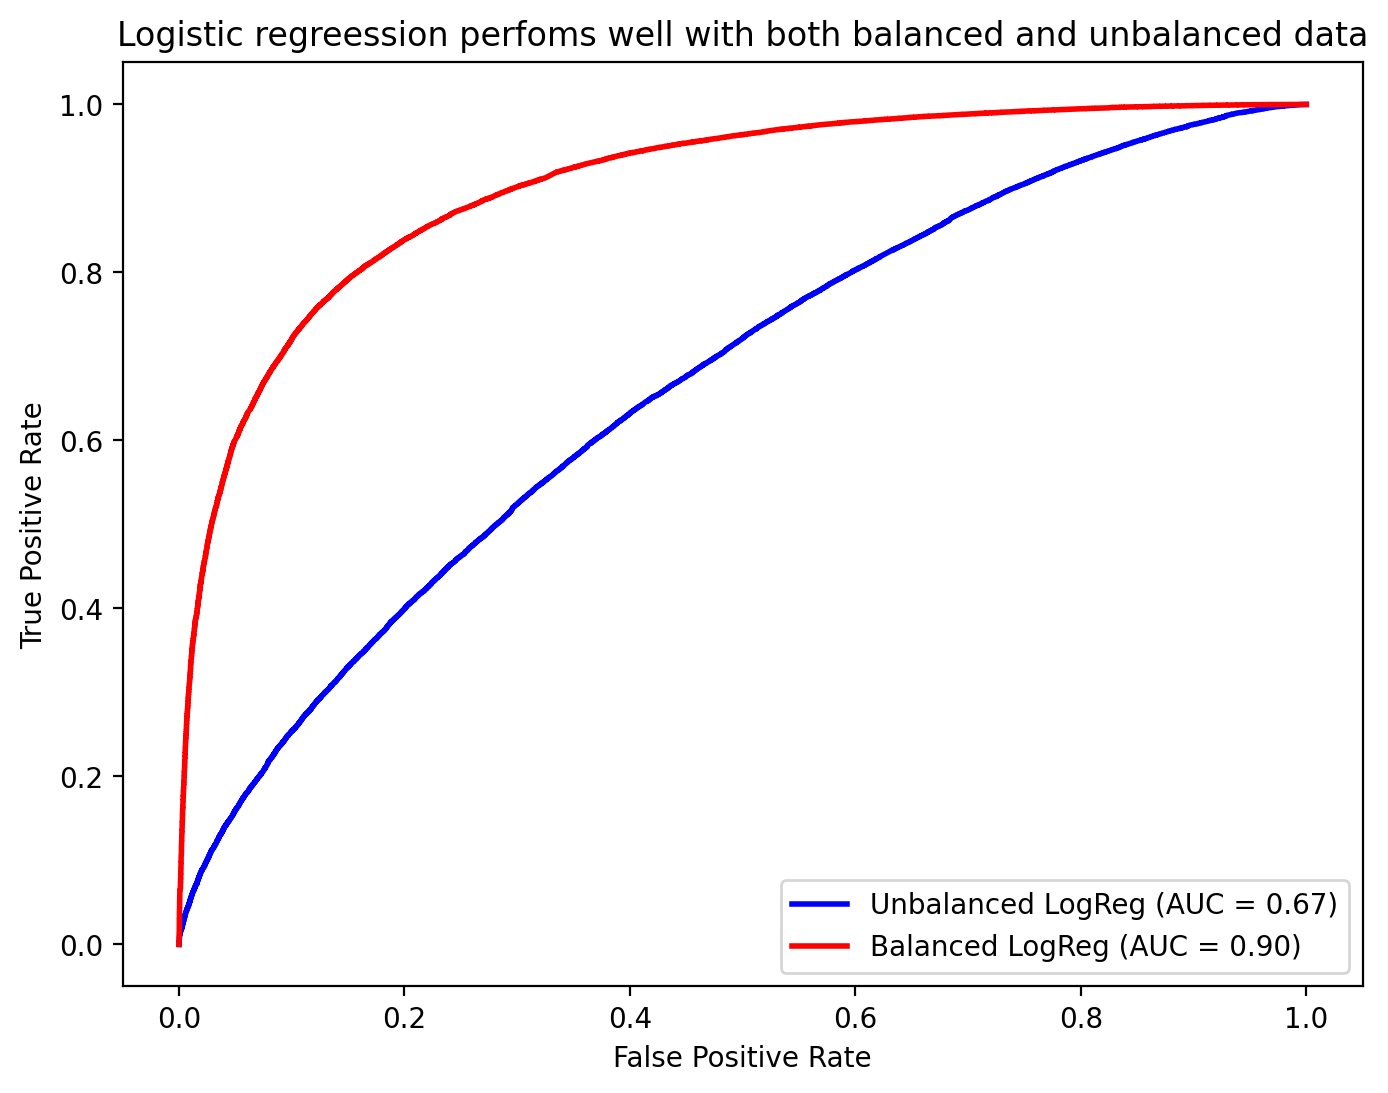

In [145]:
plt.figure(figsize=(8, 6))

# ROC curve for unbalanced model
plt.plot(fpr_unbal, tpr_unbal, color='blue', lw=2, label='Unbalanced LogReg (AUC = %0.2f)' % roc_auc1)

# ROC curve for balanced model
plt.plot(fpr_bal, tpr_bal, color='red', lw=2, label='Balanced LogReg (AUC = %0.2f)' % roc_auc2)

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic regreession perfoms well with both balanced and unbalanced data')
plt.legend()


plt.show()

In [146]:
with open('logreg_roc_data.pkl', 'wb') as f:
    joblib.dump({'fpr_unbal': fpr_unbal, 'tpr_unbal': tpr_unbal, 'roc_auc1': roc_auc1,
                 'fpr_bal': fpr_bal, 'tpr_bal': tpr_bal, 'roc_auc2': roc_auc2}, f)

Really poor precision of the 0 class, and bad recall on the 1 class. It "performs well" by guessing 0 a lot. Then when its very confident it guesses 1 and gets it right, but misclassifies many positive reviews as negative.

In [147]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.42      0.31      0.36     33949
           1       0.80      0.87      0.83    108208

    accuracy                           0.73    142157
   macro avg       0.61      0.59      0.60    142157
weighted avg       0.71      0.73      0.72    142157



In [148]:
print(classification_report(y_test, y_pred_test_bal))

              precision    recall  f1-score   support

           0       0.58      0.83      0.68     33949
           1       0.94      0.81      0.87    108208

    accuracy                           0.82    142157
   macro avg       0.76      0.82      0.78    142157
weighted avg       0.85      0.82      0.83    142157



### Original unbalanced dataset:
- **Recall for negative reviews (0)**: The recall for the negative class is 0.31. This means that only 31% of the actual negative reviews were correctly identified by the model. This is a very low recall and indicates that the model missed a large number of negative reviews.
- **Precision for negative reviews (0)**: The precision is 0.42, which indicates that out of all the reviews predicted as negative, only 42% were actually negative. This is poor. We would like a better precision and recall on the negative class
- **Overall accuracy**: While the overall accuracy is 0.73, this is largely influenced by the model's performance on the dominant positive class. The high imbalance in the dataset makes accuracy a less reliable indicator of model performance.

### After downsampling the majority (1) class:
- **Recall for negative reviews (0)**: The recall increased to 0.83, indicating that the model now correctly identifies 83% of the negative reviews. This is a substantial improvement, showing that the model became much better at detecting negative reviews.
- **Precision for negative reviews (0)**: The precision for the negative class also improved to 0.58. This means a higher proportion of reviews predicted as negative are infact negative. Ideally this would be higher too, however the recall increasing so much is already a good improvement. We identified over 80% of the negative reviews, and if the model identifies a review as negative, there is a 58% chance it is infact negative.
- **Overall Accuracy**: The overall accuracy improved to 0.82, but more importantly, the improvement is balanced across both classes.

### Key Observations:
1. **Improved Recall for Minority Class**: The most notable improvement is in the recall for the negative class, which suggests that balancing the classes helped the model to better identify the negative reviews.
   
2. **Increased Precision for Minority Class**: The improved precision indicates that after balancing, the model makes fewer false positive errors for the negative class.

3. **Better Balance in Performance**: The macro average scores, which give equal weight to each class, have improved considerably. This suggests a more balanced performance across both classes, rather than the model being biased towards the majority class.

### Conclusion:
Balancing the classes by downsampling the majority class significantly improved the model's ability to identify negative reviews without drastically compromising its ability to identify positive reviews. This change led to a more balanced and effective model, especially important in applications where detecting the minority class is crucial, like in sentiment analysis of customer reviews. This is also shown in the confusion matricies and the ROC curve.

Similar results, but better overall at guessing each class.

Understanding model mistakes:

In [149]:
y_pred_test_Ser = pd.Series(y_pred_test, index=y_test.index)


In [150]:

incorrect_guesses_unbal = y_test != y_pred_test

incorrect_v_unbal = pd.Series(y_test)[incorrect_guesses_unbal]
pred_df_unbal = pd.DataFrame(y_pred_test,y_test.index)
pred_df_unbal
ig_unbal = pd.concat([pred_df_unbal[incorrect_guesses_unbal],pd.Series(incorrect_v_unbal), test_later[incorrect_guesses_unbal]], axis=1)
ig_unbal.rename(columns={0:"guess"}, inplace=True)

In [151]:
rev_unbal = ig_unbal.loc[412231]
text_u = rev_unbal["reviewText"]
print(f"Actual: {rev_unbal['binary']}, Guess: {rev_unbal[0]}, Overall: {int(rev_unbal['overall'])}")
print(f"Review: {text_u}")

Actual: 1, Guess: 0, Overall: 4
Review: Needed headphones for the gym. Tired of earbuds falling out when I ran or later down. These wrap around the back of the head and fit snug.


In [152]:

incorrect_guesses = y_test != y_pred_test_bal

incorrect_v = pd.Series(y_test)[incorrect_guesses]
pred_df = pd.DataFrame(y_pred_test_bal,y_test.index)
pred_df
ig = pd.concat([pred_df[incorrect_guesses],pd.Series(incorrect_v), test_later[incorrect_guesses]], axis=1)
ig.rename(columns={0:"guess"}, inplace=True)

In [153]:
false_positives = ig[ig["guess"]==1]

In [154]:
headphones = false_positives["reviewText"].str.contains("headphones")
headphones[headphones].index

Index([171732,  13940, 525993, 662701,  84591, 414774, 186493,  39044, 103957,
       298434,  39623, 520898, 171328, 489422, 102183, 382596,  72147, 368866,
       697284, 104093, 104070],
      dtype='int64')

a Review it got wrong
298434, 171328, 72147

In [155]:
rev = ig.loc[298434]
text = rev["reviewText"]
print(f"Actual: {rev['binary']}, Guess: {rev[0]}, Overall: {int(rev['overall'])}")
print(f"Review: {text}")

Actual: 0, Guess: 1, Overall: 2
Review: Bought second pair, only this time I bought it for my daughter and surprise only got the headphones wrapped  around with type and no additional size buds


In [164]:
feature_values = ig.loc[298434,"1gram__10":]


In [165]:
log_clas.coef_.shape

(1, 600)

In [166]:
coefficients = log_clas_bal.coef_[0]
contributions = feature_values * coefficients
contributions.sort_values(ascending=False)


1gram__got         0.686774
1gram__size        0.521376
1gram__bought      0.360354
1gram__headphon    0.067812
1gram__slim            -0.0
                     ...   
1gram__time       -0.039522
1gram__around     -0.073433
1gram__second     -0.077836
1gram__type       -0.104202
1gram__daughter   -0.131053
Name: 298434, Length: 600, dtype: object

In [167]:
pd.DataFrame(contributions.sort_values(ascending=False)).head(5)

,298434
1gram__got,0.686774
1gram__size,0.521376
1gram__bought,0.360354
1gram__headphon,0.067812
1gram__slim,-0.0


In [168]:
pd.DataFrame(contributions.sort_values(ascending=True)).head(6)

,298434
1gram__daughter,-0.131053
1gram__type,-0.104202
1gram__second,-0.077836
1gram__around,-0.073433
1gram__time,-0.039522
1gram__thing,-0.0


We see that the positive words swayed the confidence of the model and it misclassified it. Words like love.

In [169]:
intercept = log_clas_bal.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [170]:
probability

array([0.59129458])

In [171]:
log_clas.coef_.shape

(1, 600)

In [172]:
coefficients = log_clas.coef_[0]
contributions = feature_values * coefficients
contributions.sort_values(ascending=False)


1gram__bought      0.330149
1gram__second      0.141405
1gram__got         0.130118
1gram__time        0.109857
1gram__headphon    0.103057
                     ...   
1gram__happi            0.0
1gram__hard            -0.0
1gram__type       -0.059138
1gram__around     -0.124995
1gram__daughter   -0.388583
Name: 298434, Length: 600, dtype: object

In [173]:
pd.DataFrame(contributions.sort_values(ascending=False)).head(5)

,298434
1gram__bought,0.330149
1gram__second,0.141405
1gram__got,0.130118
1gram__time,0.109857
1gram__headphon,0.103057


In [174]:
pd.DataFrame(contributions.sort_values(ascending=True)).head(5)

,298434
1gram__daughter,-0.388583
1gram__around,-0.124995
1gram__type,-0.059138
1gram__sit,-0.0
1gram__sleek,0.0


In [175]:
intercept = log_clas.intercept_

total_log_odds = contributions.sum() + intercept

probability = 1 / (1 + np.exp(-total_log_odds))

In [176]:
probability

array([0.63025049])

SHAP:


In [177]:
import shap
shap.initjs()


In [178]:
pipe_final

Pipeline(steps=[('vectorize',
                 FeatureUnion(transformer_list=[('1gram',
                                                 TfidfVectorizer(max_features=500,
                                                                 min_df=10,
                                                                 tokenizer=<function my_tokenizer at 0x14f055c10>)),
                                                ('2gram',
                                                 TfidfVectorizer(max_features=100,
                                                                 min_df=10,
                                                                 ngram_range=(2,
                                                                              2),
                                                                 tokenizer=<function my_tokenizer at 0x14f055c10>))])),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=42,
                                    solver='liblinear'))],
         verbose=True)

In [182]:
explainer = shap.Explainer(
    pipe_final[1], X_train, feature_names=feature_unbal, index=X_train.index
)
shap_values = explainer(X_test)

In [183]:
print("Positive" if y_test[412231] else "Negative", "Review:")
print(y_test[412231])

Positive Review:
1


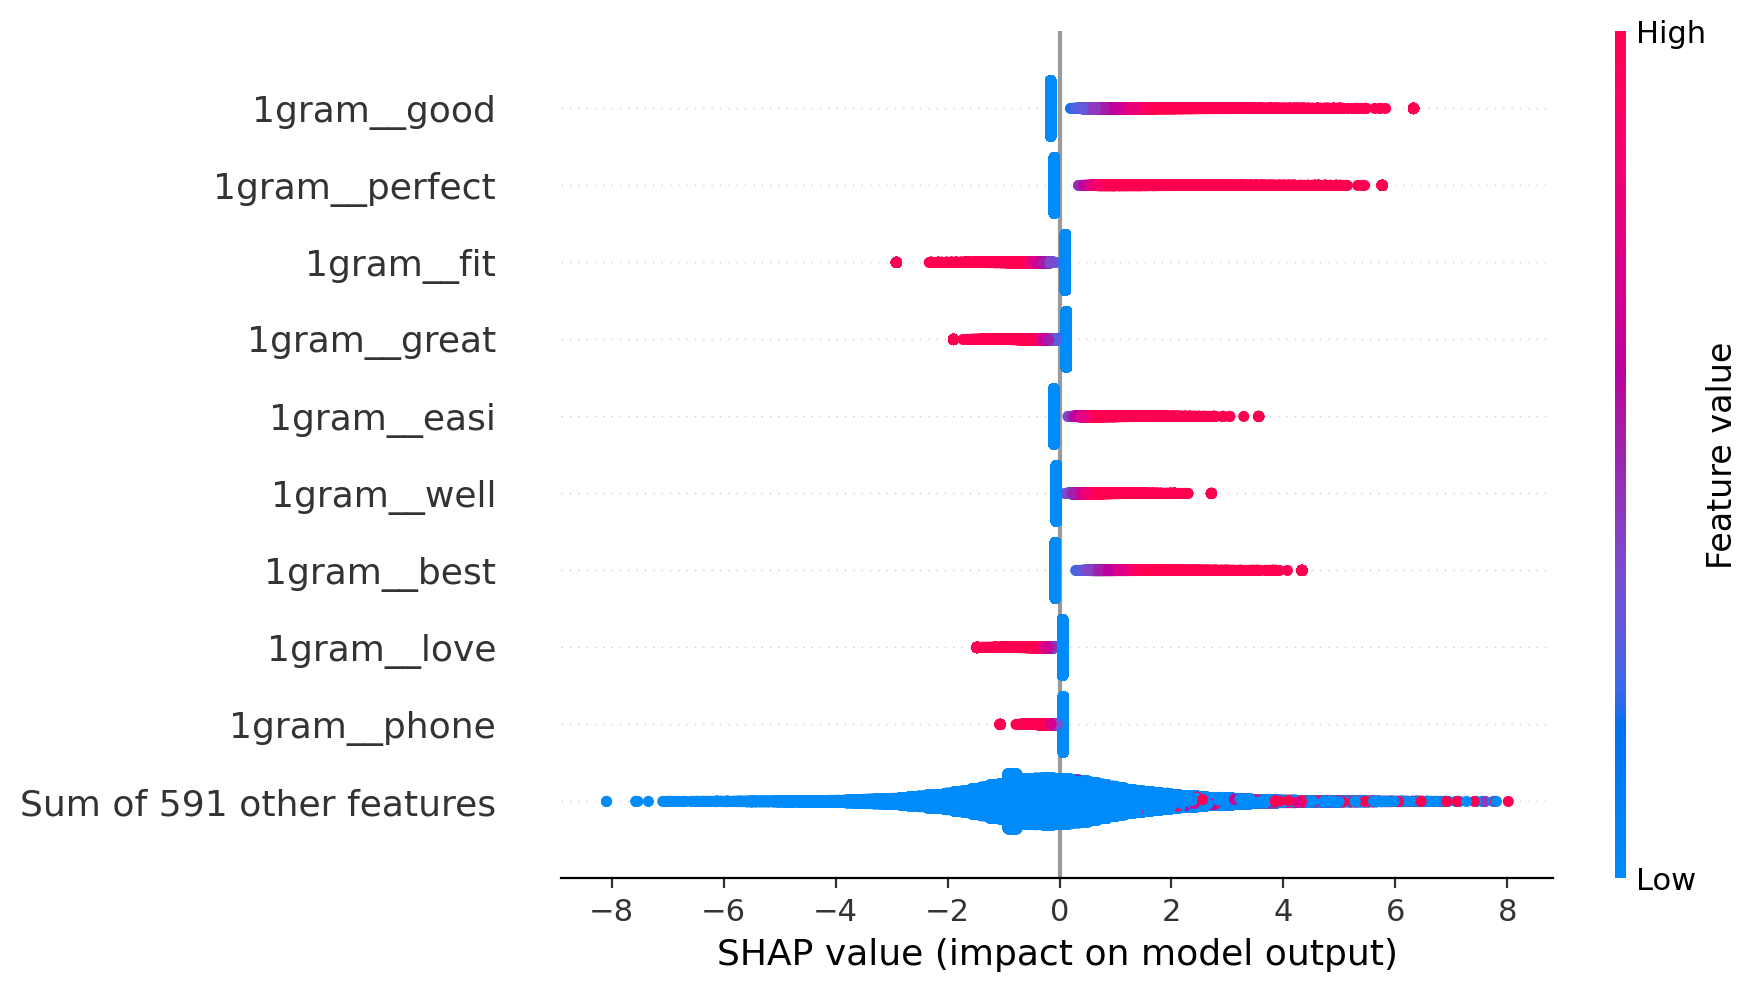

In [184]:
shap.plots.beeswarm(shap_values)

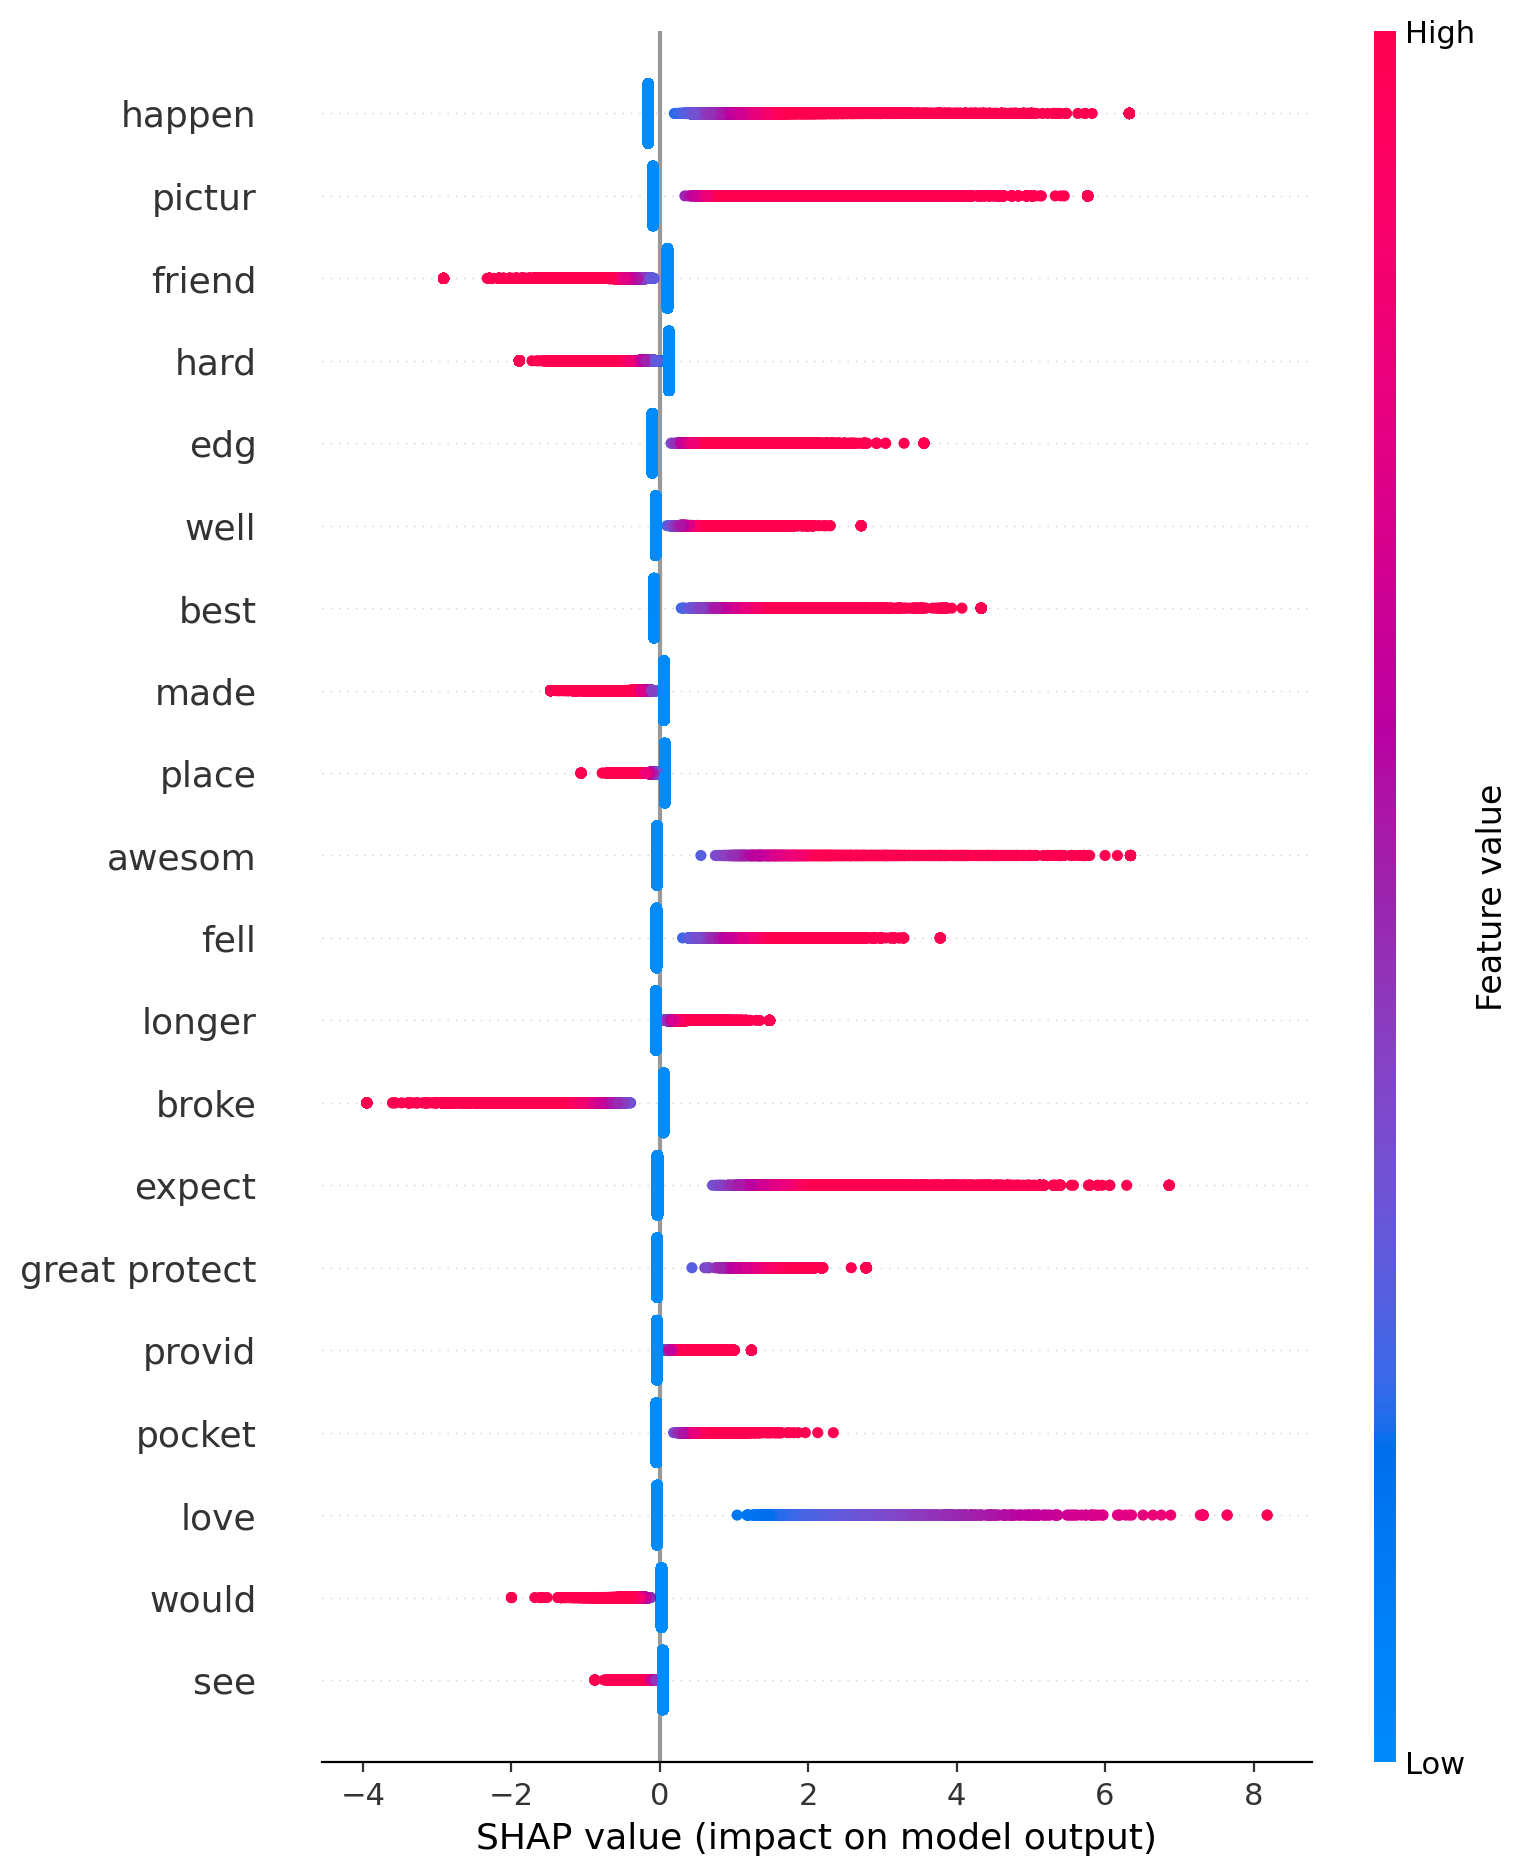

In [185]:
shap.summary_plot(shap_values, X_test, feature_names=feature_bal)

In [92]:
position = X_test.index.get_loc(412231)



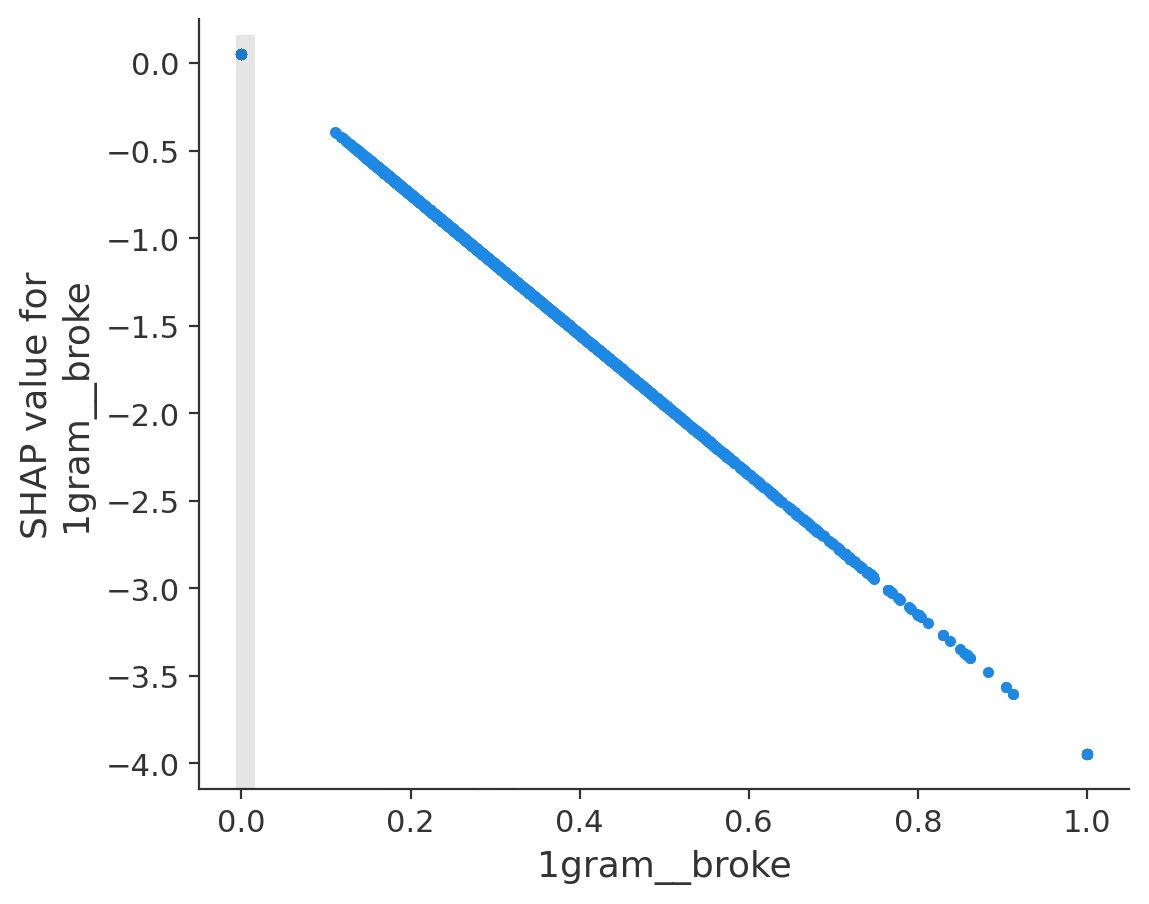

In [93]:
shap.plots.scatter(shap_values[:,"1gram__broke"])


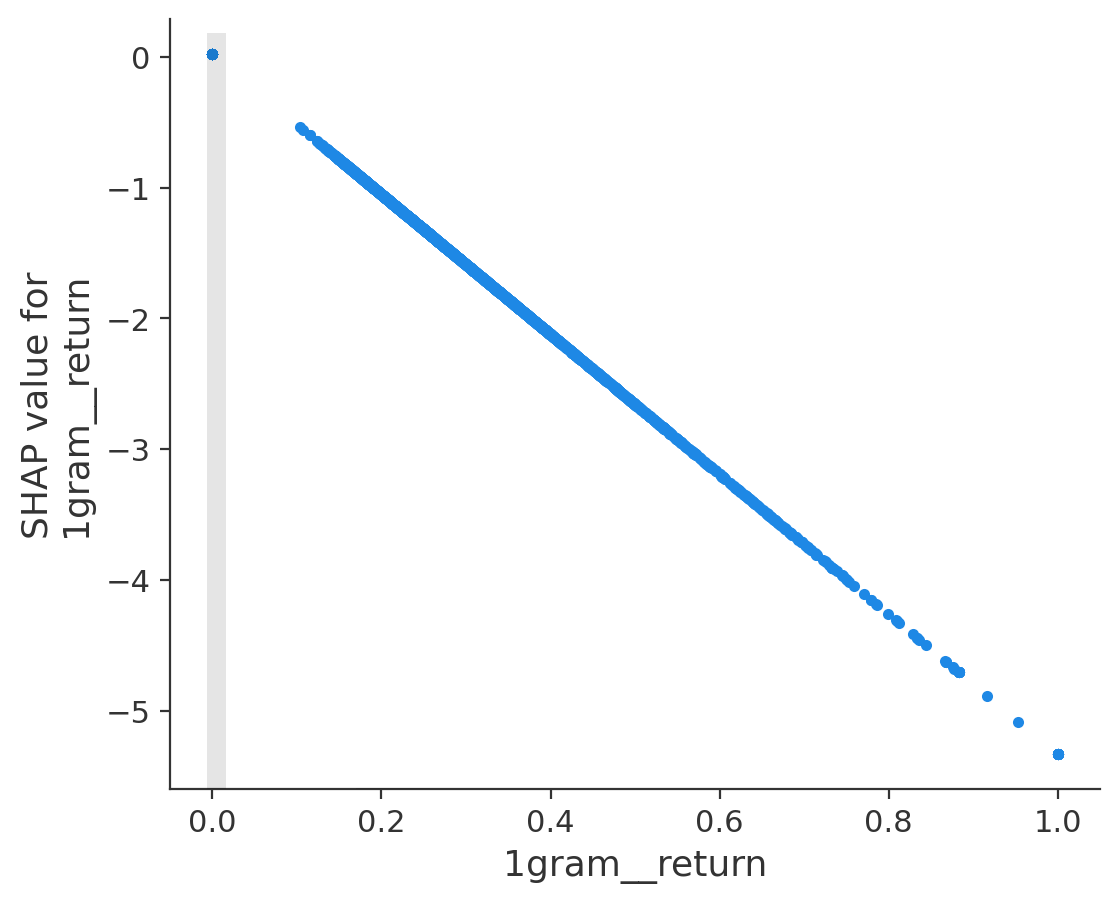

In [94]:
shap.plots.scatter(shap_values[:,"1gram__return"])


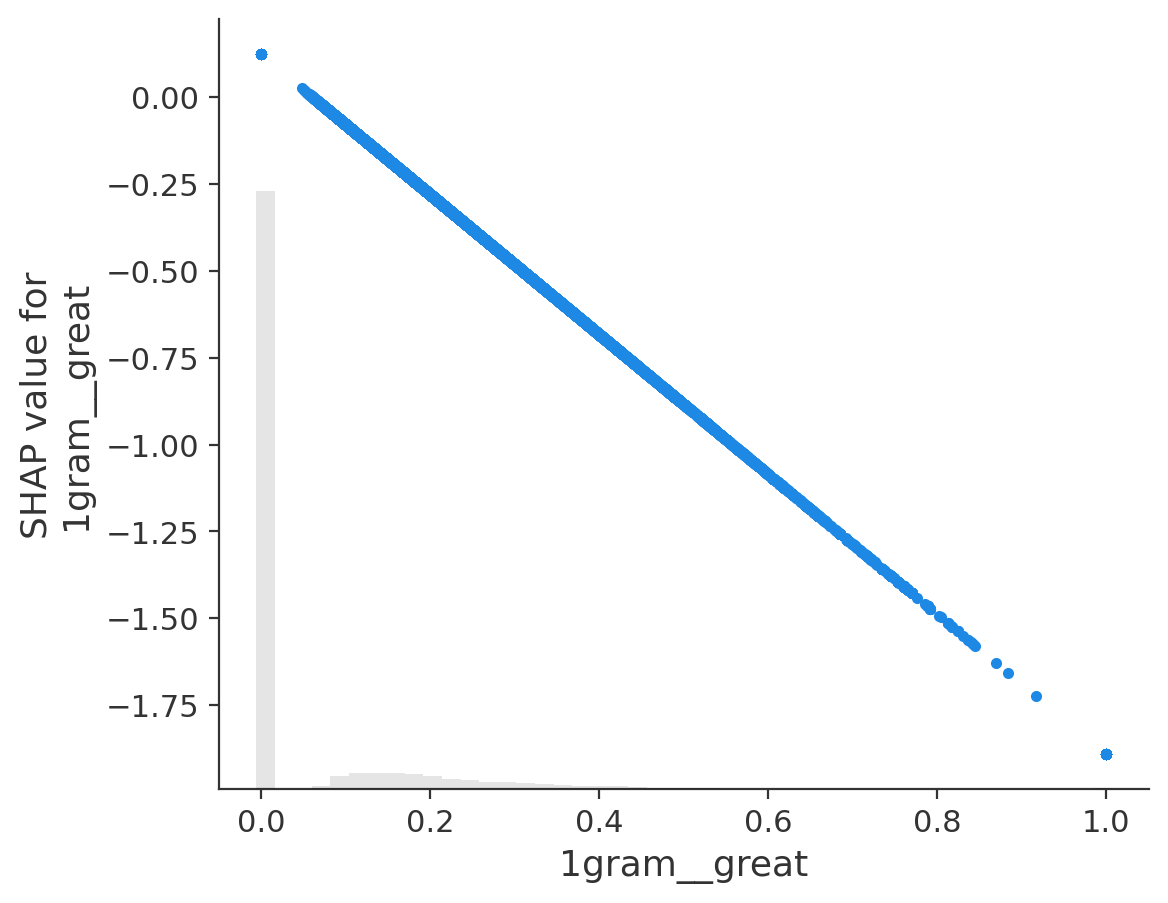

In [95]:
shap.plots.scatter(shap_values[:,"1gram__great"])


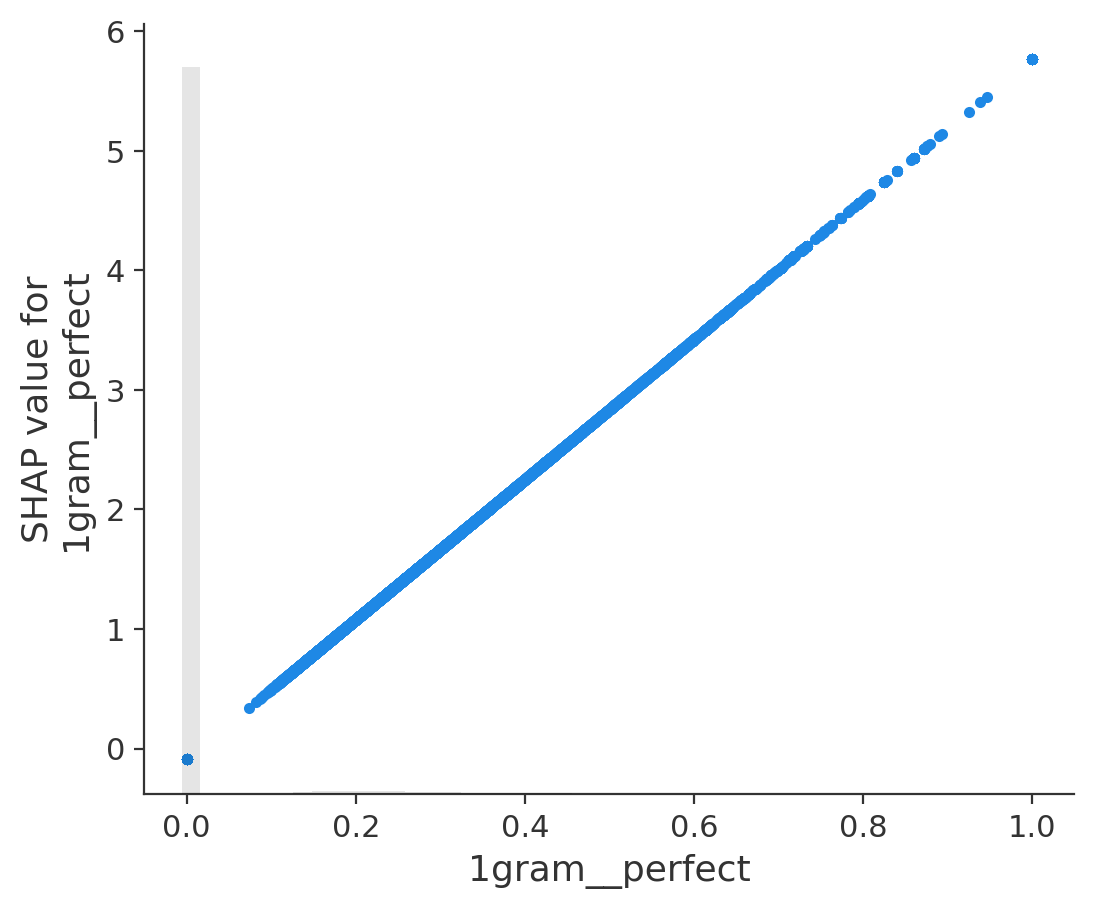

In [96]:
shap.plots.scatter(shap_values[:,"1gram__perfect"])


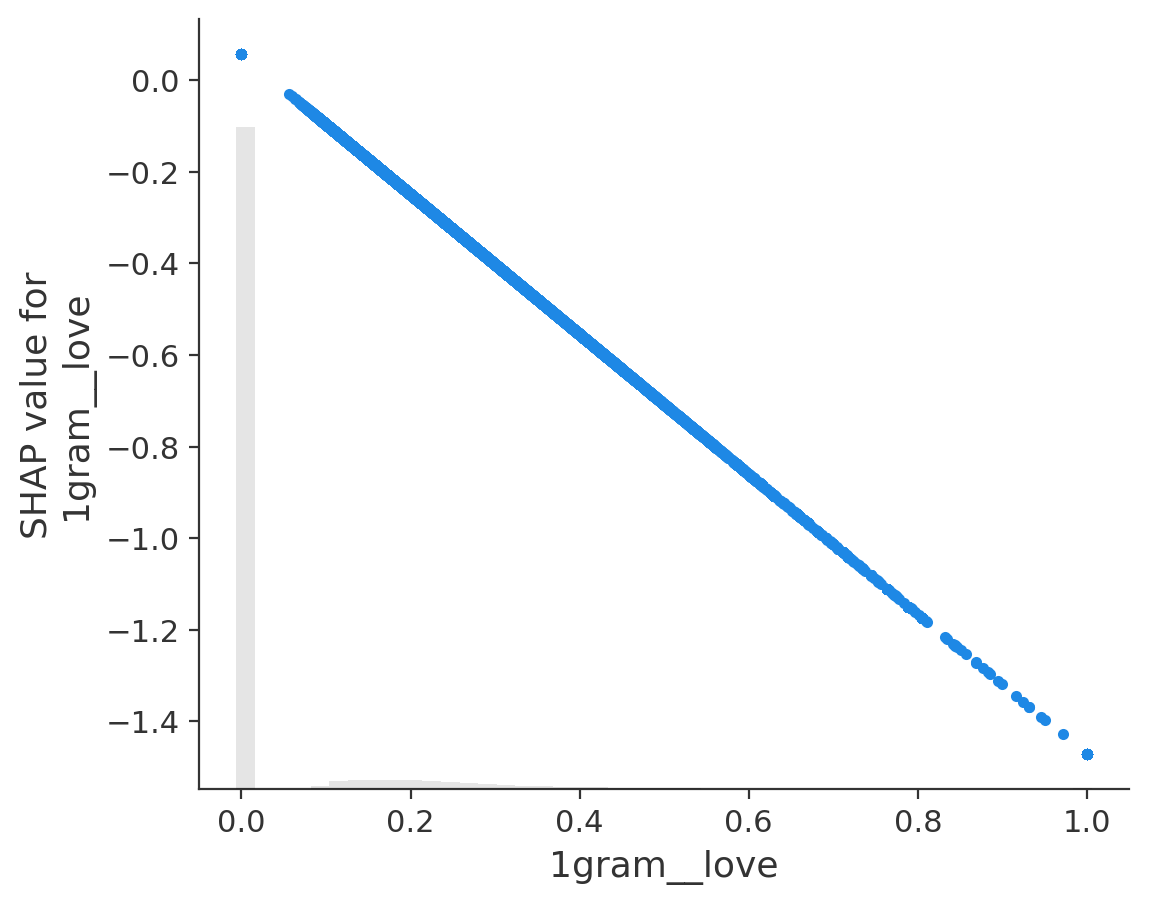

In [97]:
shap.plots.scatter(shap_values[:,"1gram__love"])


In [98]:
shap.plots.force(shap_values[position])

In [99]:
explainer_bal = shap.Explainer(
    pipe_final_bal[1], X_train_bal, feature_names=pipe_final_bal[0].get_feature_names_out(), index=X_train_bal.index
)
shap_values_bal = explainer_bal(X_test)

In [115]:
shap.plots.force(shap_values_bal[position])

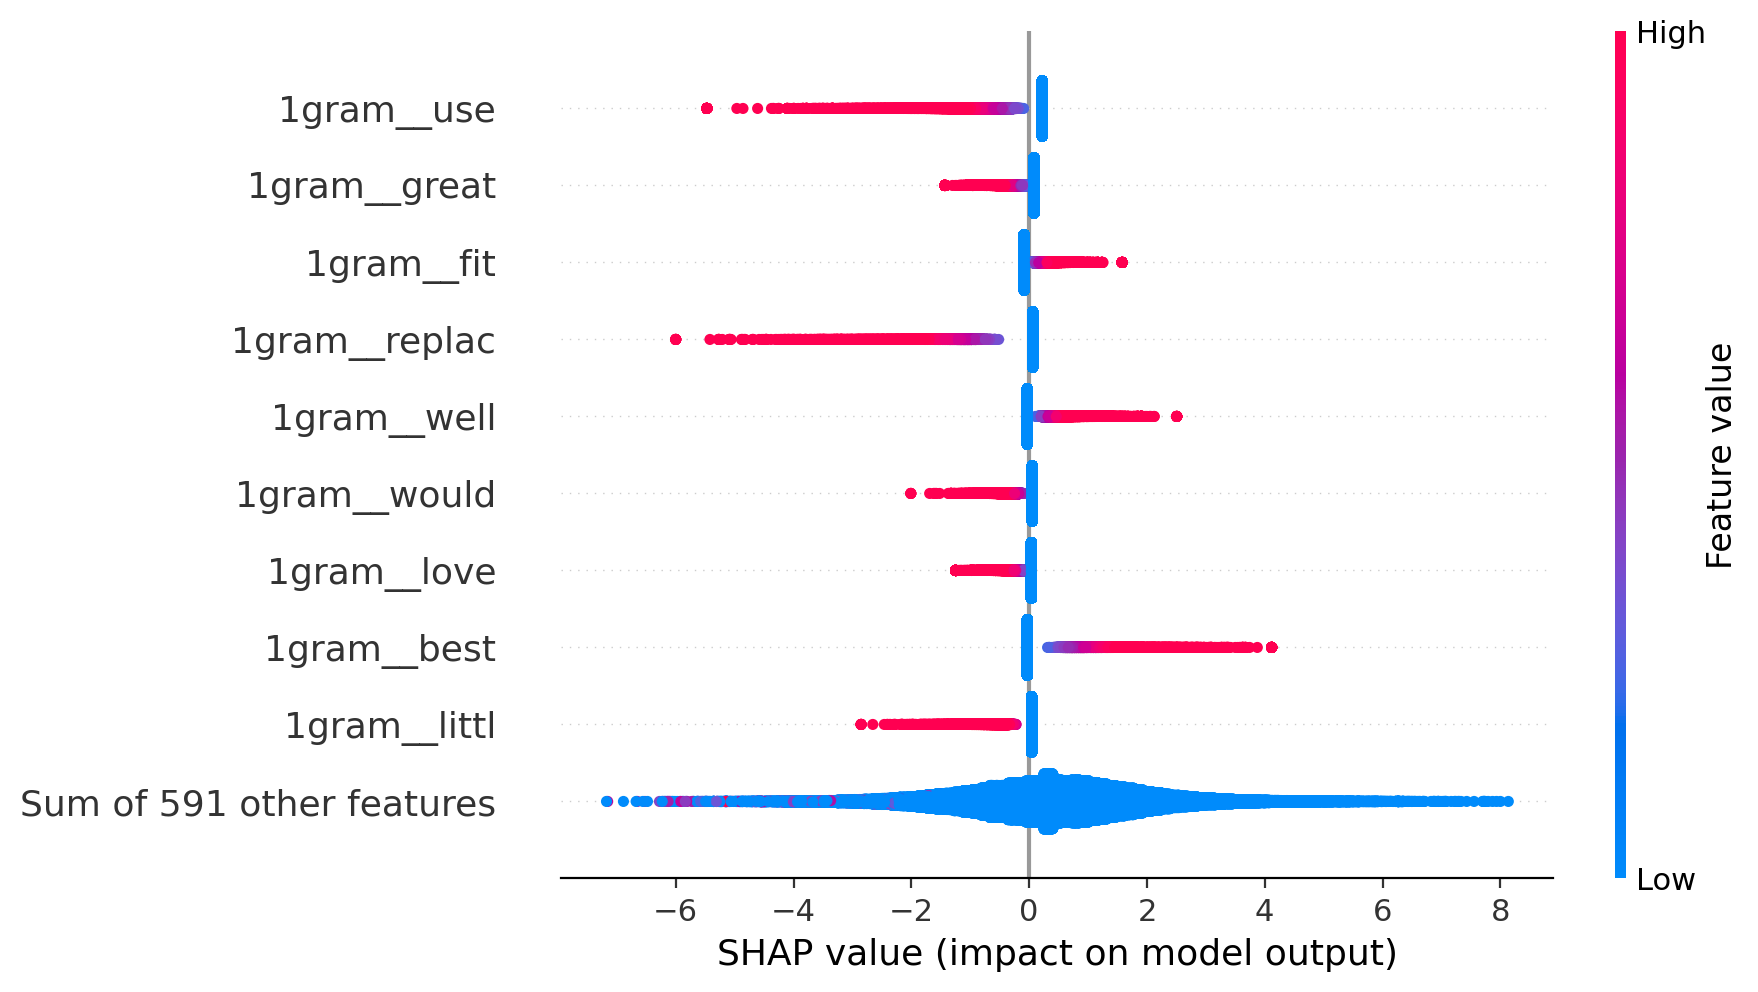

In [101]:
shap.plots.beeswarm(shap_values_bal)

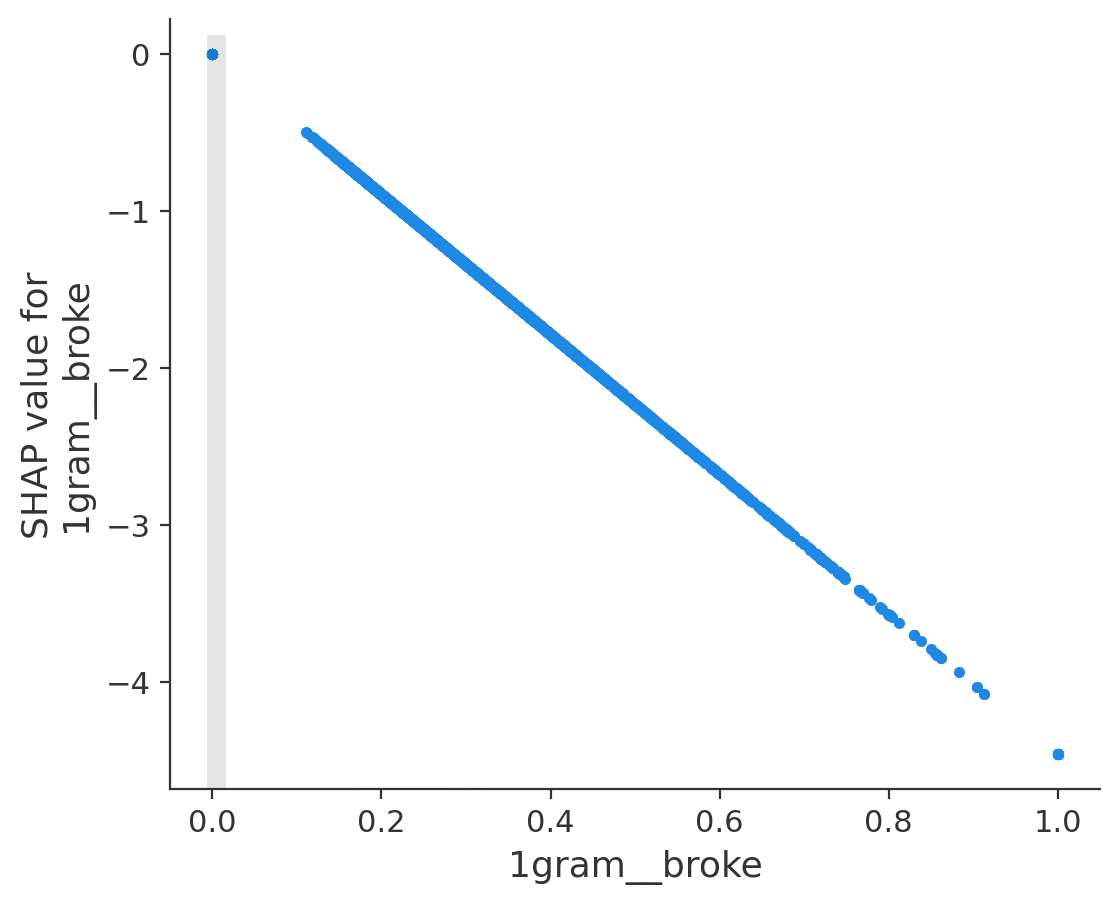

In [102]:
shap.plots.scatter(shap_values_bal[:,"1gram__broke"])
